In [3]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import os
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from sklearn.model_selection import train_test_split


In [5]:
class DualInputDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, input_size, num_classes, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.input_size = input_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.indices = np.arange(len(self.image_paths))
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def preprocess_image(self, path):
        img = load_img(path, target_size=self.input_size)
        img = img_to_array(img) / 255.0
        return img

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        paths_1 = [self.image_paths[i] for i in indices]
        paths_2 = random.sample(self.image_paths, self.batch_size)  # Different set

        X1 = np.array([self.preprocess_image(p) for p in paths_1])
        X2 = np.array([self.preprocess_image(p) for p in paths_2])

        y = np.array([self.labels[i] for i in indices])
        y = to_categorical(y, num_classes=self.num_classes)

        return (X1, X2), y


In [6]:
def build_dual_input_model(input_shape, num_classes):
    input_1 = Input(shape=input_shape)
    input_2 = Input(shape=input_shape)

    def conv_branch(input_layer):
        x = Conv2D(32, (3, 3), activation='relu')(input_layer)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Conv2D(64, (3, 3), activation='relu')(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Flatten()(x)
        return x

    branch_1 = conv_branch(input_1)
    branch_2 = conv_branch(input_2)

    merged = Concatenate()([branch_1, branch_2])
    x = Dense(128, activation='relu')(merged)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[input_1, input_2], outputs=output)
    return model


In [7]:
dataset_dir = '/kaggle/input/imagesoasis/Data'

class_names = sorted(os.listdir(dataset_dir))
label_dict = {name: idx for idx, name in enumerate(class_names)}

image_paths = []
image_labels = []

for class_name in class_names:
    class_dir = os.path.join(dataset_dir, class_name)
    for fname in os.listdir(class_dir):
        if fname.endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(class_dir, fname))
            image_labels.append(label_dict[class_name])

# Train-validation split
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, image_labels, test_size=0.2, stratify=image_labels, random_state=42
)

In [9]:
train_gen = DualInputDataGenerator(train_paths, train_labels, batch_size=32, input_size=(224, 224), num_classes=4)
val_gen = DualInputDataGenerator(val_paths, val_labels, batch_size=32, input_size=(224, 224), num_classes=4)

model = build_dual_input_model(input_shape=(224, 224, 3), num_classes=4)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_gen, validation_data=val_gen, epochs=10)


Epoch 1/10
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 1570s 715ms/step - accuracy: 0.8058 - loss: 0.5348 - val_accuracy: 0.9546 - val_loss: 0.1468
Epoch 2/10
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 462s 213ms/step - accuracy: 0.9378 - loss: 0.1621 - val_accuracy: 0.9900 - val_loss: 0.0384
Epoch 3/10
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 431s 199ms/step - accuracy: 0.9752 - loss: 0.0691 - val_accuracy: 0.9957 - val_loss: 0.0175
Epoch 4/10
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 448s 207ms/step - accuracy: 0.9848 - loss: 0.0452 - val_accuracy: 0.9970 - val_loss: 0.0109
Epoch 5/10
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 450s 207ms/step - accuracy: 0.9855 - loss: 0.0385 - val_accuracy: 0.9980 - val_loss: 0.0076
Epoch 6/10
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 422s 195ms/step - accuracy: 0.9901 - loss: 0.0284 - val_accuracy: 0.9991 - val_loss: 0.0037
Epoch 7/10
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 530s 245ms/step - accuracy: 0.9910 - loss: 0.0246 - val_accuracy: 0.9995 - val_loss: 0.0026
Epoch 8/10
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 460s 212ms/step - a

In [11]:
# Evaluate the model on the test generator
test_loss, test_acc = model.evaluate(val_gen, steps=len(val_gen))

# Print the test accuracy
print(f"Test Accuracy: {test_acc:.4f}")


540/540 ━━━━━━━━━━━━━━━━━━━━ 81s 150ms/step - accuracy: 0.9995 - loss: 0.0016
Test Accuracy: 0.9995


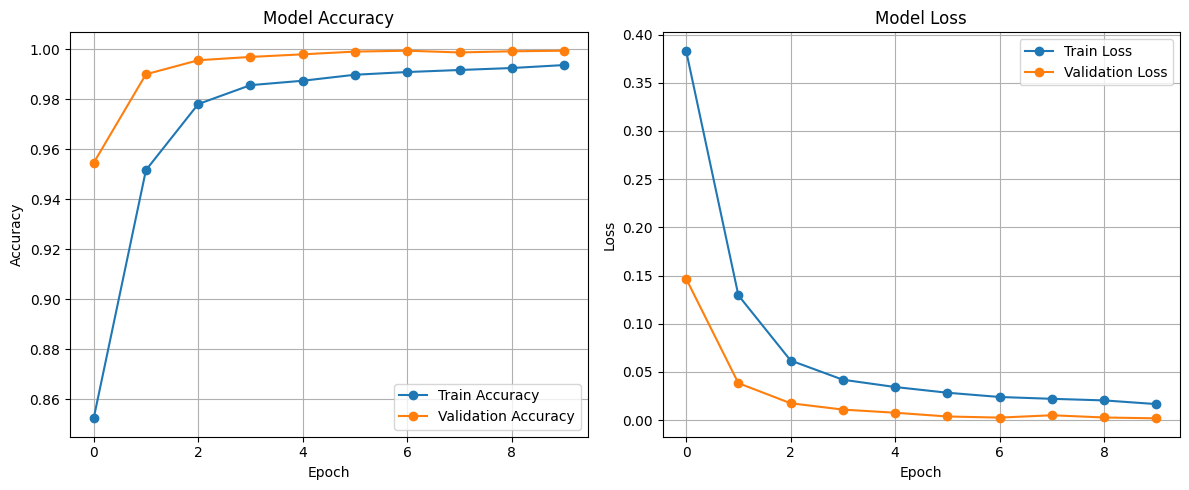

In [12]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [13]:
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 222, 222, 32)   │            896 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 222, 222, 32)   │            896 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 111, 111, 32)   │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 111, 111, 32)   │              0 │ conv2d_6[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 109, 109, 64)   │         18,496 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 109, 109, 64)   │         18,496 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 54, 54, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 54, 54, 64)     │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 186624)         │              0 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 186624)         │              0 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 373248)         │              0 │ flatten_2[0][0],       │
│ (Concatenate)             │                        │                │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │     47,775,872 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 4)              │            516 │ dropout_1[0][0]        │
└──────────────────────

 Total params: 143,445,518 (547.20 MB)

 Trainable params: 47,815,172 (182.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 95,630,346 (364.80 MB)

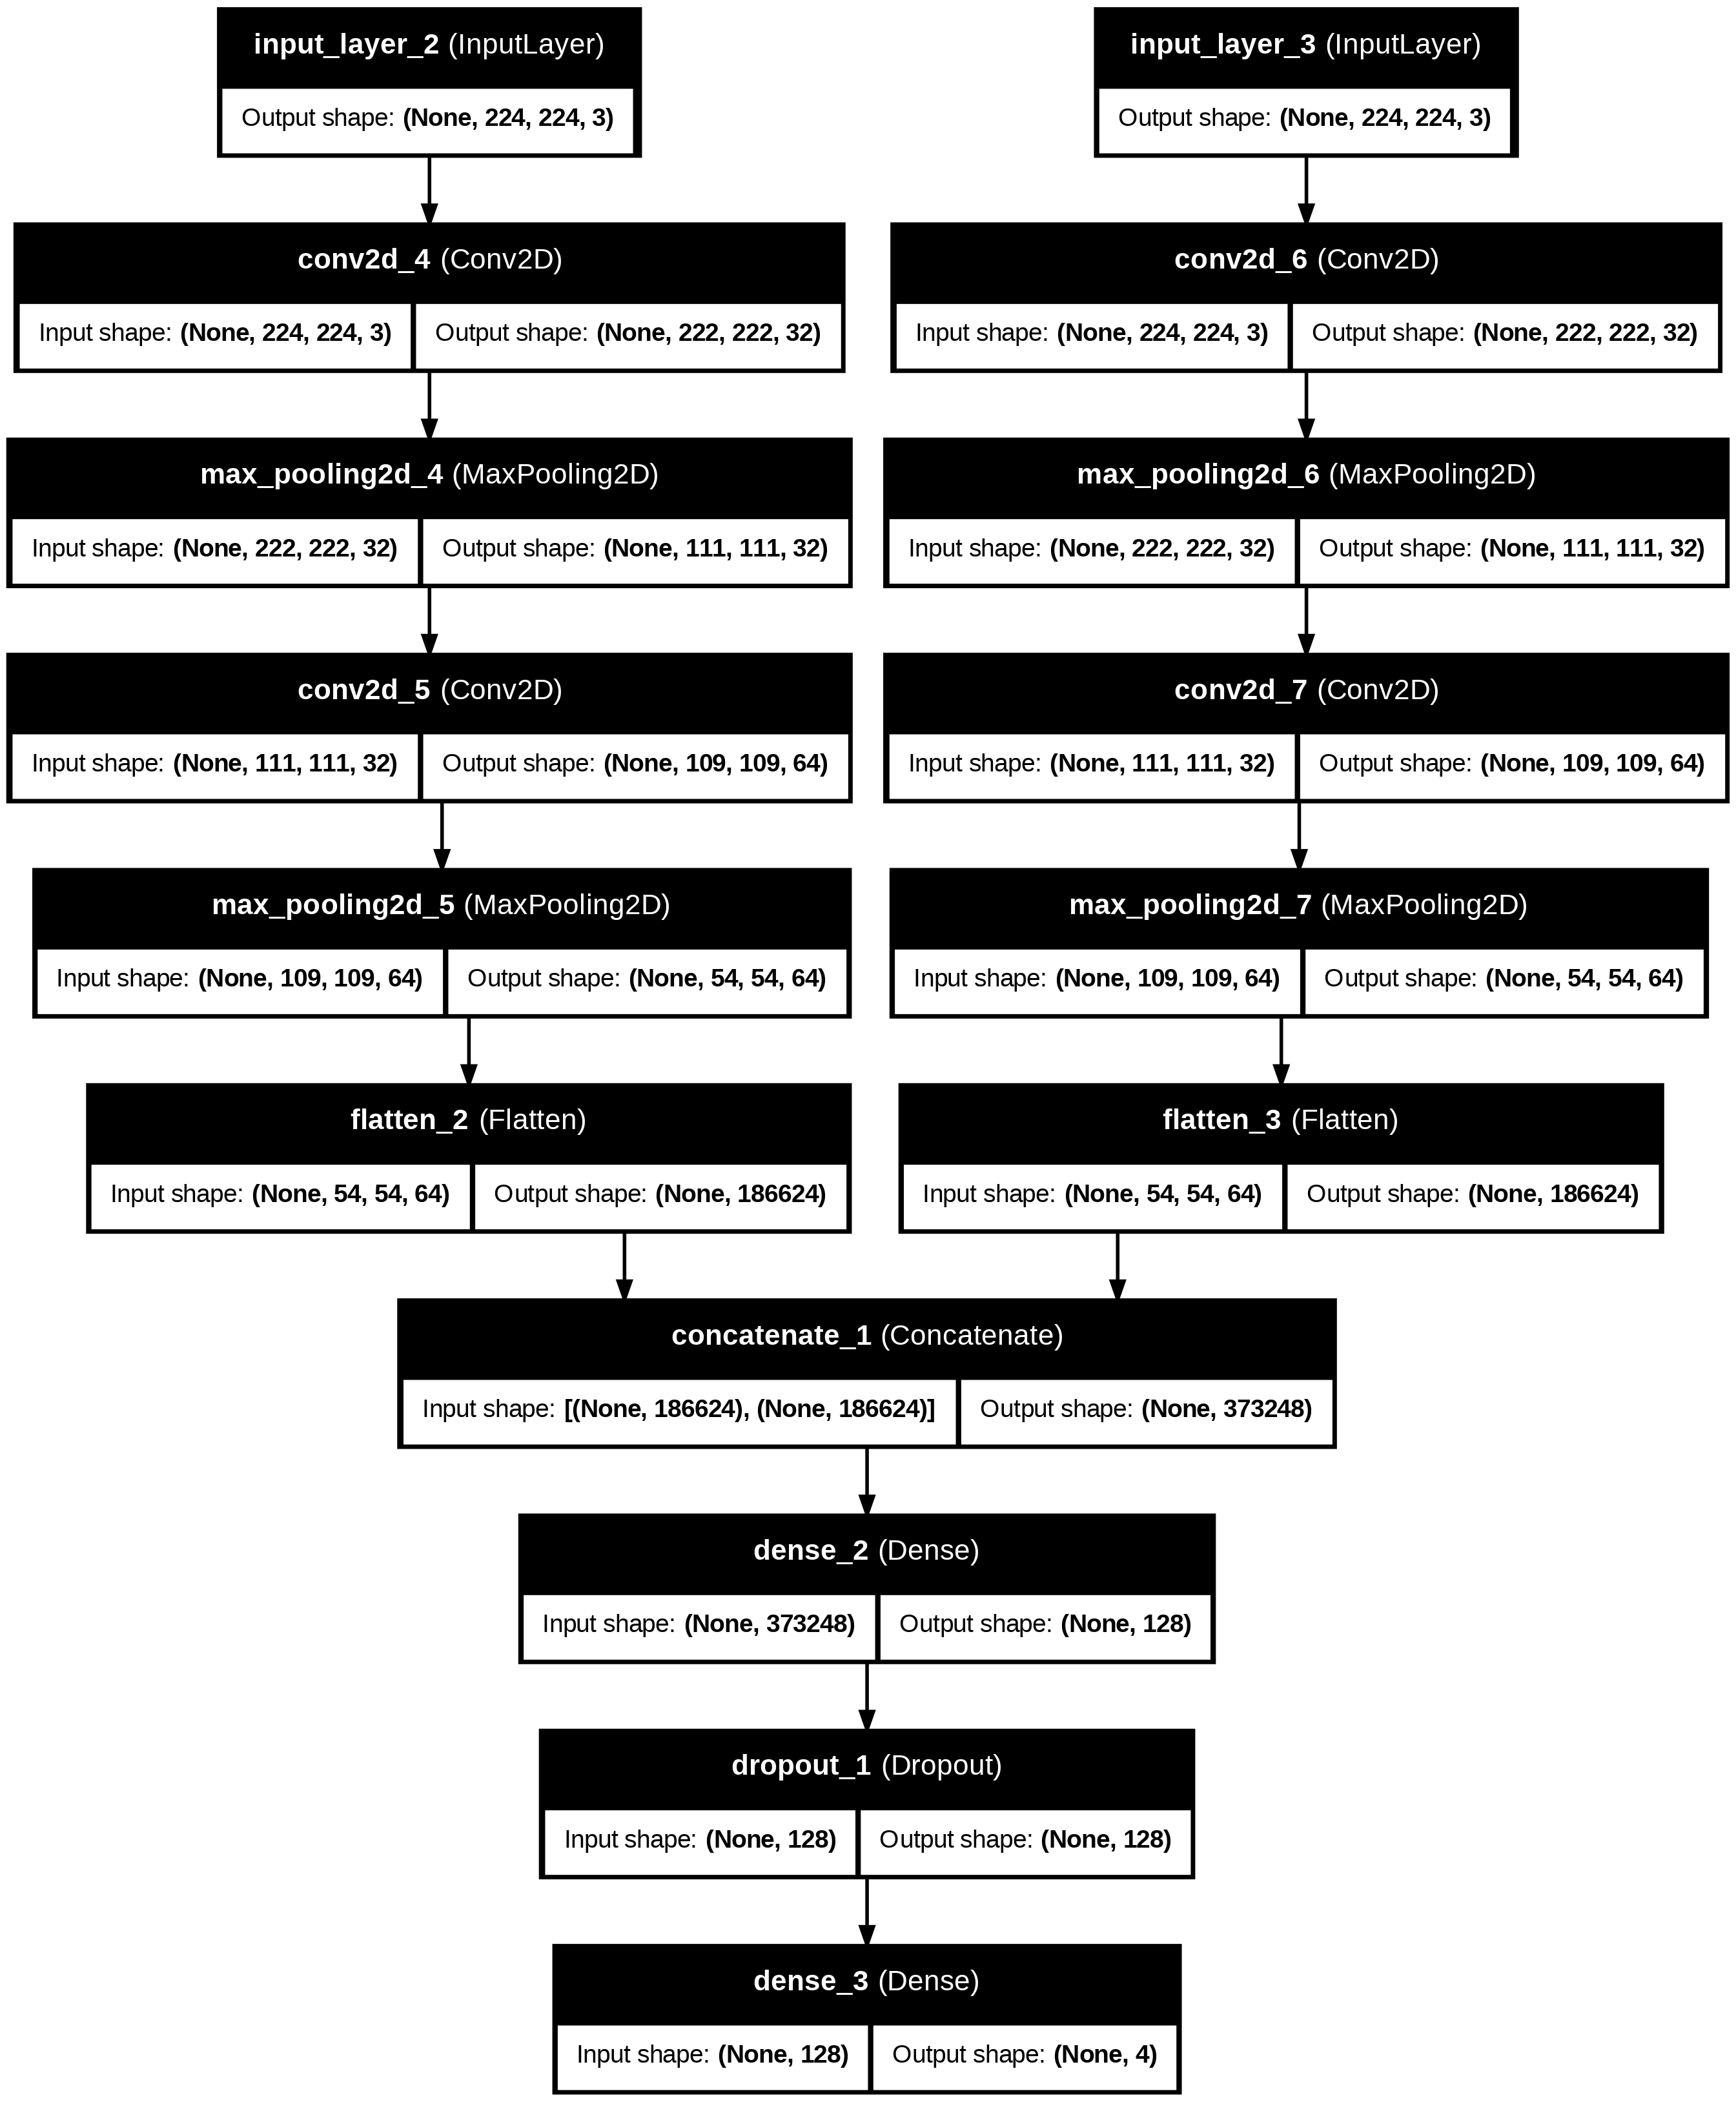

In [15]:
# Visualize and save model architecture to a PNG file
plot_model(model, to_file='dual_input_cnn_model.png', 
           show_shapes=True, 
           show_layer_names=True,
           expand_nested=True)
